In [46]:
#=
using Pkg
Pkg.add("CSV")
Pkg.add("OrdinaryDiffEq")
Pkg.add("StatsPlots")
Pkg.add("Turing")
Pkg.add("BenchmarkTools")
=#

In [1]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, OrdinaryDiffEq, StatsPlots, Turing, DataFrames
using BenchmarkTools
using Random; Random.seed!(2)

include("Functions.jl")
#Model\Functions.jl
ss = [0.19221352181589382, 0.025370121153103352, 0.003470710756175975]
# ss = [0.1980838489553699, 0.3398764604660583, 0.021953988325962473]

3-element Vector{Float64}:
 0.19221352181589382
 0.025370121153103352
 0.003470710756175975

In [2]:
@parameters Vm_GPI Vm_PFK2 Vm_FBP Vm_ALD # V values. Vm are Vmax forward for each enzyme.

C_ATP = exp(-5.643)*1000 #M to mM
C_ADP = exp(-6.616)*1000
C_cit = exp(-3.930)*1000
C_AMP = exp(-12.151)*1000
C_PFKM = 4*10^-5
C_AMPK = 5.7875*10^-1 #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
C_Pi = 1
C_G6P = exp(-7.762)*1000
C_GAP = exp(-15.059)*1000 
C_DHAP = exp(-13.059)*1000 

L_PFKM = 2*10^9
L_PFK2 = 1*10^-3
#=
V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2]
=#
Keq_GPI =  0.492
Keq_PFKM = 1.96675 *10^3
Keq_PFK2 = 16.0
Keq_FBP = 56.4458
Keq_ALD = 0.0173

Kf_GPI = 0.3
Kr_GPI = 0.123 #0.123
Ki_ATP = 0.1
Ki_cit = 0.1 #
Ka_f6p = 6*10^-2
Ka_f16bp = 0.35 #0.35 for PFKM and 0.65 for PFKL
Ka_AMP = 0.3
Ka_f26bp = 5.5*10^-8 # 5.5*10^-3
Kc_PFKM = 15.5*10^2/(4*10^-5) # Changed from 15.5*10^2/4*10^-5
K_f6p = 6*10^-2
K_ATP = 6.8*10^-2
K_f16bp = 0.65
K_ADP = 0.54
Kc_AMPK = 0.1 # Check this
v_P = 0.005 # Check this
K2_ATP = 0.15
K2_f6p = 0.032
K2_f26bp = 0.008
K2_ADP = 0.062
K_FBP_f26bp = 1*10^-3
K_FBP_f6p = 25*10^-3
K_Pi = 0.23 #
KAld_f16bp = 5*10^-2
K_GAP = 0.189
K_DHAP = 3.5*10^-2 

@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vm_GPI/Kf_GPI)*(C_G6P-(f6p/Keq_GPI))/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)
    
N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = ((C_PFKM*(Kc_PFKM/(K_f6p*K_ATP))*(C_ATP*f6p - C_ADP*f16bp/Keq_PFKM))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (Kc_AMPK*C_AMPK)/((Kc_AMPK*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = (Vm_PFK2/(K2_ATP*K2_f6p))*((C_ATP*f6p)-(C_ADP*f26bp)/Keq_PFK2)/
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = (Vm_FBP/(K_FBP_f26bp))*(f26bp-(f6p*C_Pi)/Keq_FBP)/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = (Vm_ALD/KAld_f16bp)*(f16bp-(C_GAP*C_DHAP)/Keq_ALD)/
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (4):
  Vm_FBP
  Vm_GPI
  Vm_PFK2
  Vm_ALD
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

In [3]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]


V = [Vm_GPI => 4*10^4,
    Vm_PFK2 => 40,
    Vm_FBP => 12, 
    Vm_ALD => 6*10^2]

p= V

tspan = (0.0, 10)
prob = ODEProblem(sys, u0, tspan, p, jac = true)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 3-element Vector{Float64}:
 0.001
 0.001
 0.001

In [3]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2]
p= V

tspan = (0.0, 10)
prob = ODEProblem(sys, u0, tspan, p, jac = true)

@btime sol = solve(prob, Rodas4(), save_everystep = false);
# 117.700 μs (61 allocations: 9.39 KiB)
#try with QNDS instead of Rodas4

  117.700 μs (61 allocations: 9.39 KiB)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 10.0
u: 2-element Vector{Vector{Float64}}:
 [0.001, 0.001, 0.001]
 [0.19808384895536987, 0.3398764604660582, 0.021953988325962463]

In [6]:
@btime sol = solve(prob, QNDF(), save_everystep = false)
#  142.000 μs (69 allocations: 9.80 KiB)

  142.000 μs (69 allocations: 9.80 KiB)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 10.0
u: 2-element Vector{Vector{Float64}}:
 [0.001, 0.001, 0.001]
 [0.1980838096286308, 0.33987753585098973, 0.021954018841714835]

In [ ]:
print(sol[end])

# [0.1980838489553699, 0.3398764604660583, 0.021953988325962473]

In [8]:
#=
Vm_GPI = 4.8*10^4
Vm_PFK2 = 41.6
Vm_FBP = 11.78 
Vm_ALD = 6.75*10^2
p=[Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD]
=#

4-element Vector{Float64}:
 48000.0
    41.6
    11.78
   675.0

In [9]:
#=
sol = solve(prob, Rodas4(); p = p, saveat = 0.1)
ss1 = sol[end]
=#

3-element Vector{Float64}:
 0.19221352181589382
 0.025370121153103352
 0.003470710756175975

In [20]:
print(ss)

[0.19221352181589382, 0.025370121153103352, 0.003470710756175975]

In [6]:
@model function mymodel(data, prob)
    Vm_GPI ~ LogNormal(log(4.8*10^4), 1) 
    Vm_PFK2 ~ LogNormal(log(41.6), 1) 
    Vm_FBP ~ LogNormal(log(11.78), 1)
    Vm_ALD ~ LogNormal(log(6.75*10^2), 1) 
    sigma ~ LogNormal(-1.2, 0.7)
    p=[Vm_GPI, Vm_PFK2, Vm_ALD, Vm_FBP] # test if the order is importen - I don't think it is 
    sol = solve(prob, QNDF(), save_everystep = false)
    ss1 = sol[end]
    for i in 1:length(data)
        data[i] ~ LogNormal(log(ss1[i]), sigma)
    end
end

@model function mymodelRodas4(data, prob)
    Vm_GPI ~ LogNormal(log(4.8*10^4), 1) 
    Vm_PFK2 ~ LogNormal(log(41.6), 1) 
    Vm_FBP ~ LogNormal(log(11.78), 1)
    Vm_ALD ~ LogNormal(log(6.75*10^2), 1) 
    sigma ~ LogNormal(-1.2, 0.7)
    p=[Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD]
    sol = solve(prob, Rodas4(), save_everystep = false)
    ss1 = sol[end]
    for i in 1:3
        data[i] ~ LogNormal(log(ss1[i]), sigma)
    end
end

#try with QNDS

mymodelRodas4 (generic function with 2 methods)

In [10]:
ss01 = ss[[1,2]]

2-element Vector{Float64}:
 0.19221352181589382
 0.025370121153103352

In [13]:

model = mymodel(ss01, prob) # test if it works with only steady state for f6p and f16bp (without f26bp)
model01 = mymodel(ss, prob)
#model01 = mymodelRodas4(ss, prob)

DynamicPPL.Model{typeof(mymodel), (:data, :prob), (), (), Tuple{Vector{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ModelingToolkit.MTKParameters{Tuple{Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}, Nothing, Nothing}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#683"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x74bfd5fb, 0xe9eb3c1d, 0x425fedbd, 0xe2c55f24, 0x7e8d9984), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xd046699d, 0x9a4a8e22, 0x768c3a09, 0x853fc542, 0x7f31dde9), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ModelingToolkit.var"#_jac#688"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x5ff

In [14]:

sampler = NUTS()

samples = 1000

chain = sample(model, sampler, samples)
chain1 = sample(model01, sampler, samples)


Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.40625
└ @ Turing.Inference C:\Users\alber\.julia\packages\Turing\lkUBK\src\mcmc\hmc.jl:191
Sampling   0%|█                                         |  ETA: 0:00:01
Sampling   1%|█                                         |  ETA: 0:00:04
Sampling   1%|█                                         |  ETA: 0:00:04
Sampling   2%|█                                         |  ETA: 0:00:04
Sampling   2%|█                                         |  ETA: 0:00:04
Sampling   3%|██                                        |  ETA: 0:00:04
Sampling   3%|██                                        |  ETA: 0:00:05
Sampling   4%|██                                        |  ETA: 0:00:04
Sampling   4%|██                                        |  ETA: 0:00:04
Sampling   5%|██                                        |  ETA: 0:00:04
Sampling   5%|███                                       |  ETA: 0:00:04
Samplin

Chains MCMC chain (1000×17×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.29 seconds
Compute duration  = 2.29 seconds
parameters        = Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean          std        mcse    ess_bulk   ess_tail      ⋯
      Symbol      Float64      Float64     Float64     Float64    Float64   Fl ⋯

      Vm_GPI   76618.1288   91773.2095   2831.2020   2123.7541   838.9454    0 ⋯
     Vm_PFK2      69.1493      83.5983      2.7993   1295.8150   644.1145    1 ⋯
      Vm_FBP      19.4278      23.6159      0.6970   1629.9808   908.2284    1 ⋯
      Vm_ALD    1141.2339    1721.3069     52.7791   1536.8869   788.3338    1 ⋯
       sigma       1.4641       0.45

In [15]:
chain

Chains MCMC chain (1000×17×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.51 seconds
Compute duration  = 2.51 seconds
parameters        = Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters         mean           std        mcse    ess_bulk   ess_tail     ⋯
      Symbol      Float64       Float64     Float64     Float64    Float64   F ⋯

      Vm_GPI   80007.1089   116552.7274   4998.5508   1045.3990   676.2912     ⋯
     Vm_PFK2      67.1638       79.0094      2.5999   1748.2913   814.3506     ⋯
      Vm_FBP      20.1077       30.4540      1.1673    909.0883   643.9655     ⋯
      Vm_ALD    1217.0735     1556.2113     53.2501   1581.0826   715.8108     ⋯
       sigma       1.3387        0.4

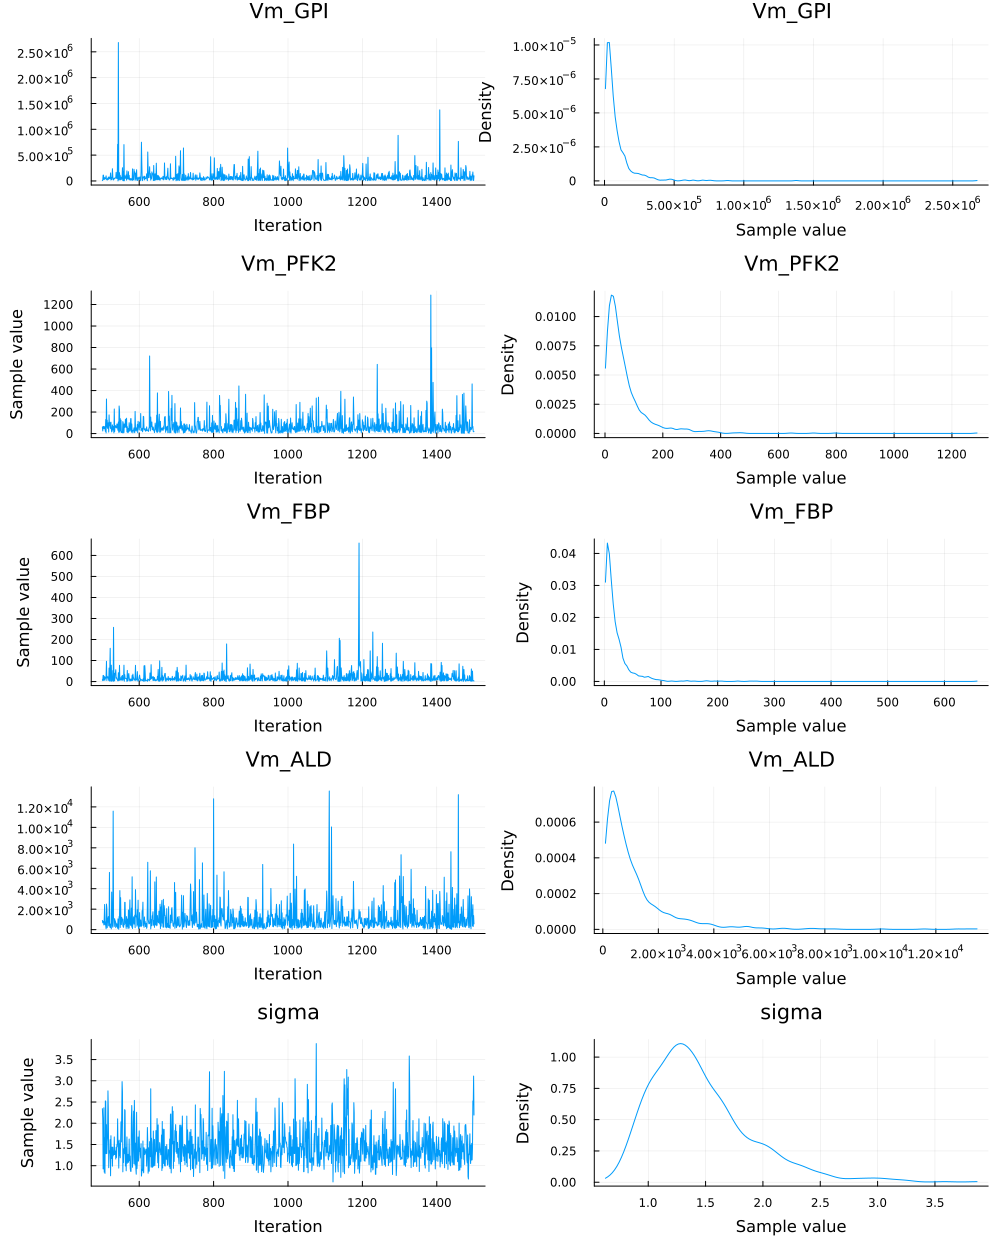

In [87]:
# visualize results

plot(chain1)

In [88]:
sol_ss = zeros(300,3)
posterior_samples = sample(chain1[[:Vm_GPI, :Vm_PFK2, :Vm_FBP, :Vm_ALD]], 300; replace=false)
i=1
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob, Rodas4(), p=p, save_everystep= false)
    sol_ss[i,:] = sol_p[end]
    i = i+1 
end


In [80]:
print(log.(ss))

[-1.6491484320803516, -3.674183129934838, -5.663395877128781]

In [71]:
sol_ss

300×3 Matrix{Float64}:
 0.181423  0.0117438   0.00327397
 0.178651  0.0481564   0.00331147
 0.197559  0.0116544   0.00352781
 0.198801  0.0164379   0.00378361
 0.187862  0.00265822  0.00334924
 0.204591  0.0878362   0.00364608
 0.187214  0.0686678   0.00361478
 0.185102  0.0348688   0.00360389
 0.203858  0.0782257   0.00363196
 0.179585  0.0129059   0.00352533
 ⋮                     
 0.175981  0.00826572  0.00313761
 0.162683  0.0103121   0.0028994
 0.196464  0.178576    0.0035032
 0.177163  0.0192843   0.00315258
 0.182728  0.0042836   0.0033418
 0.202608  0.0456822   0.00359401
 0.191568  0.00169643  0.00344553
 0.162586  0.00468301  0.00372076
 0.190475  0.0151827   0.00341586

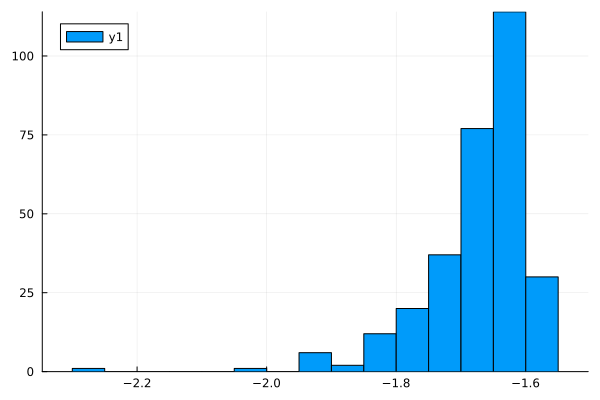

In [89]:
histogram(log.(sol_ss[:,1]),bins=30)
